In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import snntorch as snn
from snntorch import utils
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
from snntorch import functional

import matplotlib.pyplot as plt
import numpy as np

from trainer import *

from deepr import DeepR

import pickle

import tonic

from IPython.display import HTML

In [2]:

print(" CSNN Trained on NMNIST")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Training Parameters
batch_size=196
data_path='./tmp/data/nmnist'
slice_meta_path = "./tmp/NMNIST_sliced/"
num_classes = 10  # MNIST has 10 output classes

frame_time = 10

num_steps = 32 #i.e. the number of frames to feed the SNN

#
transform1 = tonic.transforms.Compose([tonic.transforms.ToFrame(sensor_size=(34,34,2),n_time_bins=num_steps),lambda x: x.astype(np.float32)]) 

nmnist_train = tonic.datasets.NMNIST(data_path, train=True)
nmnist_test = tonic.datasets.NMNIST(data_path, train=False)


train_nmnist_mem = tonic.MemoryCachedDataset(nmnist_train)
test_nmnist_mem = tonic.MemoryCachedDataset(nmnist_test)

slicer = tonic.slicers.SliceByTime(32*frame_time*1000,31*frame_time*1000,False)
#59 allow an overlap such that we start a new slice at every possible frame.
#however,
 
#NOTE careful , you will need to regenerate the metadata after changing parameters, takes about 30 seconds to generate the slices
#slice our dataset into a samples of frame groups - we do not need an entire sample at once
train_sliced_nmnist = tonic.SlicedDataset(train_nmnist_mem,transform=transform1,slicer=slicer,)#metadata_path=slice_meta_path+"train/")
test_sliced_nmnist = tonic.SlicedDataset(test_nmnist_mem,transform=transform1,slicer=slicer,)#metadata_path=slice_meta_path+"test/")

#dont bother using disk cached dataset, it doesnt speed things up
#dont bother changing the overlap window either... 
#yes,dataloading is the slowest part of training


train_sampler = torch.utils.data.RandomSampler(train_sliced_nmnist, generator=gtrain,replacement=False)
test_sampler = torch.utils.data.RandomSampler(test_sliced_nmnist, generator=gtest,replacement=False)

train_loader = DataLoader(train_sliced_nmnist,shuffle=False,batch_size=batch_size,drop_last=False,pin_memory=True,sampler=train_sampler,num_workers=1)
test_loader = DataLoader(test_sliced_nmnist,shuffle=False,batch_size=batch_size,drop_last=False,pin_memory=True,sampler=test_sampler,num_workers=1)

print("Train batches:",len(train_loader))
print("Test batches:",len(test_loader))

 CSNN Trained on NMNIST
Using device: cuda
Train batches: 307
Test batches: 52


Useful to know what a convolutional layers output dimension is given by $n_{out}=\frac{n_{in}+2p-k}{s}+1$, 
with default padding=0 stride=1 $n_{out}=n_{in}-k+1$.
For max pool with defaults, $\lfloor\frac{n}{2}\rfloor$.

8 - eight
torch.Size([32, 2, 34, 34])


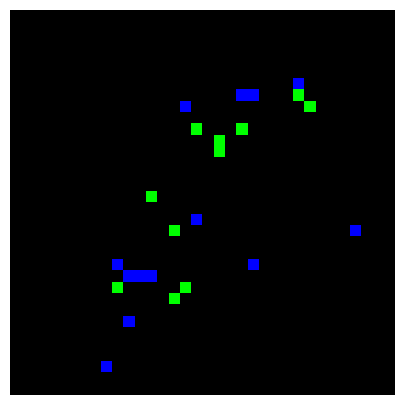

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [3]:

#if you want to create more samples you can change the overlap
a = next(iter(test_loader))
print(nmnist_test.classes[a[1][0]])
print(a[0][0].shape)
animation = tonic.utils.plot_animation(frames=a[0][0])
display(HTML(animation.to_jshtml()))

In [4]:
################ MNIST Model ##############################################################

# layer parameters
beta = 0.95 #leak rate
lr=5e-4

spike_grad1 = surrogate.atan() 

class Net(nn.Module):

    def __init__(self,c = None):
        super().__init__()

        self.loss = functional.ce_count_loss(num_classes=num_classes)
        self.accuracy_metric = functional.accuracy_rate

        #initialise neuron connections
        self.layers = nn.ModuleList([
            nn.Conv2d(2, 16, 3,padding=1),
            nn.Conv2d(16, 16, 3,padding=1),
            nn.MaxPool2d(2),
            nn.Conv2d(16,64,3,padding=1),
            nn.Conv2d(64,64,3,padding=1),
            nn.MaxPool2d(2),
            nn.Linear(4096,256),
            nn.Dropout(0.5),
            nn.Linear(256,num_classes)
        ])

        # initialize neurons
        self.neurons = nn.ModuleList(
            [snn.Leaky(beta=0.95,threshold=1,spike_grad=spike_grad1)] * len(self.layers)
        )

        self.to(device)

        #pytorch creates the tensors to represent the network layout and weights for each layer; snntorch provides the model that operates on the entire tensor (at each layer).
        if c is not None:
            self.deepr = DeepR(self.layers,lr,[0,1,3,4,6,8],connectivity=c,device=device)
  


    def forward(self,x): #x is input data
        #events should be treated as spikes i.e. already encoded

        # Initialize hidden states
        mem = []
        for i in range(len(self.layers)):
            mem.append(self.neurons[i].init_leaky())
        
        # record spike outputs
        spk_rec = []

        for step in range(num_steps):
            #form inputs
            spk_i = x[:,step]


            for i in range(len(self.layers)):
                if(i==6): #need to flatten from pooling to Linear
                    spk_i = torch.flatten(spk_i,start_dim=1)

                if(i==7):
                    spk_i=self.layers[i](spk_i)
                    continue

                cur_i = self.layers[i](spk_i)
                spk_i, mem[i] = self.neurons[i](cur_i,mem[i])
                        
            spk_rec.append(spk_i)
            


        return torch.stack(spk_rec, dim=0)
    
###################################################################################



Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 6.12%
----------------
Iteration: 50
Training loss: 1.10
Validation loss: 0.82
Validation accuracy: 73.98%
Training accuracy: 66.84%
----------------
Iteration: 100
Training loss: 0.43
Validation loss: 0.46
Validation accuracy: 83.67%
Training accuracy: 86.73%
----------------
Iteration: 150
Training loss: 0.26
Validation loss: 0.24
Validation accuracy: 93.37%
Training accuracy: 91.84%
----------------
Iteration: 200
Training loss: 0.16
Validation loss: 0.24
Validation accuracy: 92.35%
Training accuracy: 95.41%
----------------
Iteration: 250
Training loss: 0.13
Validation loss: 0.15
Validation accuracy: 95.92%
Training accuracy: 95.41%
----------------
Iteration: 300
Training loss: 0.08
Validation loss: 0.19
Validation accuracy: 95.41%
Training accuracy: 97.96%
----------------


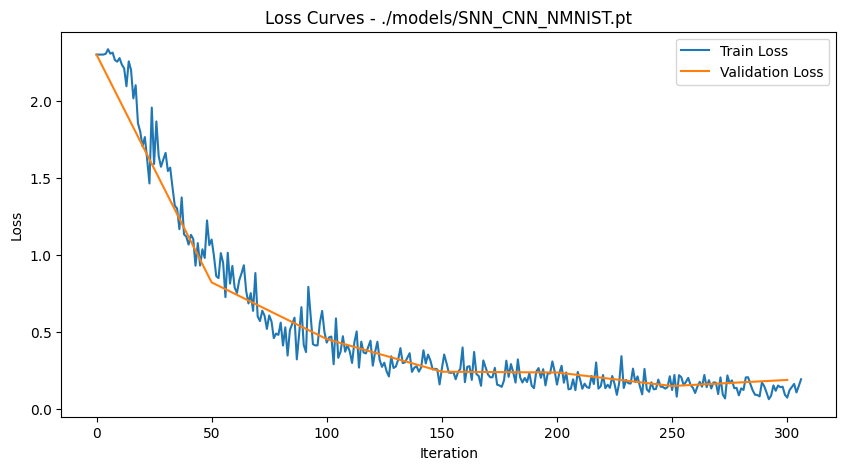

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 95.50%
----


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 6.12%
----------------
Iteration: 50
Training loss: 0.83
Validation loss: 0.63
Validation accuracy: 79.59%
Training accuracy: 70.92%
----------------
Iteration: 100
Training loss: 0.43
Validation loss: 0.35
Validation accuracy: 89.29%
Training accuracy: 85.71%
----------------
Iteration: 150
Training loss: 0.28
Validation loss: 0.18
Validation accuracy: 94.39%
Training accuracy: 90.82%
----------------
Iteration: 200
Training loss: 0.17
Validation loss: 0.23
Validation accuracy: 94.39%
Training accuracy: 93.88%
----------------
Iteration: 250
Training loss: 0.15
Validation loss: 0.13
Validation accuracy: 96.94%
Training accuracy: 93.88%
----------------
Iteration: 300
Training loss: 0.10
Validation loss: 0.20
Validation accuracy: 93.37%
Training accuracy: 96.94%
----------------


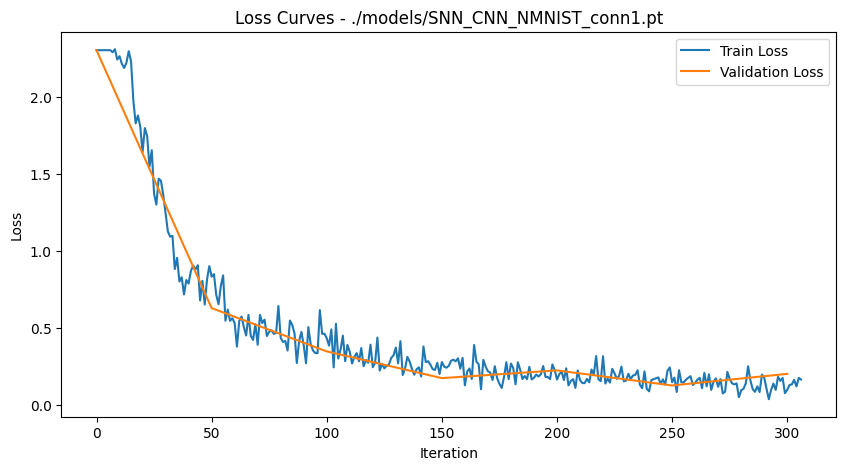

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 96.25%


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 6.12%
----------------
Iteration: 50
Training loss: 1.39
Validation loss: 1.16
Validation accuracy: 65.31%
Training accuracy: 58.16%
----------------
Iteration: 100
Training loss: 0.76
Validation loss: 0.60
Validation accuracy: 79.59%
Training accuracy: 76.02%
----------------
Iteration: 150
Training loss: 0.54
Validation loss: 0.55
Validation accuracy: 79.59%
Training accuracy: 80.10%
----------------
Iteration: 200
Training loss: 0.53
Validation loss: 0.58
Validation accuracy: 82.14%
Training accuracy: 79.59%
----------------
Iteration: 250
Training loss: 0.14
Validation loss: 0.22
Validation accuracy: 95.41%
Training accuracy: 94.39%
----------------
Iteration: 300
Training loss: 0.16
Validation loss: 0.27
Validation accuracy: 92.35%
Training accuracy: 94.90%
----------------


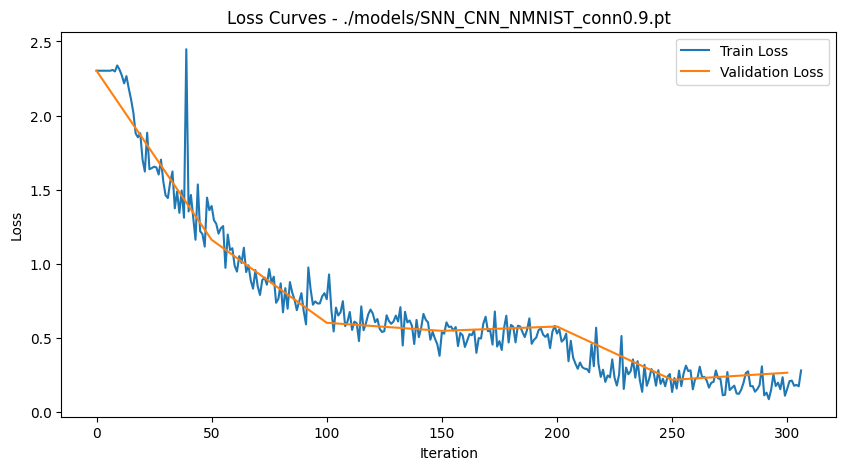

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 93.31%


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 6.12%
----------------
Iteration: 50
Training loss: 1.26
Validation loss: 0.82
Validation accuracy: 76.53%
Training accuracy: 63.78%
----------------
Iteration: 100
Training loss: 0.49
Validation loss: 0.41
Validation accuracy: 85.71%
Training accuracy: 86.73%
----------------
Iteration: 150
Training loss: 0.34
Validation loss: 0.26
Validation accuracy: 90.82%
Training accuracy: 86.73%
----------------
Iteration: 200
Training loss: 0.22
Validation loss: 0.23
Validation accuracy: 93.37%
Training accuracy: 93.88%
----------------
Iteration: 250
Training loss: 0.14
Validation loss: 0.15
Validation accuracy: 95.92%
Training accuracy: 94.90%
----------------
Iteration: 300
Training loss: 0.11
Validation loss: 0.19
Validation accuracy: 93.37%
Training accuracy: 95.41%
----------------


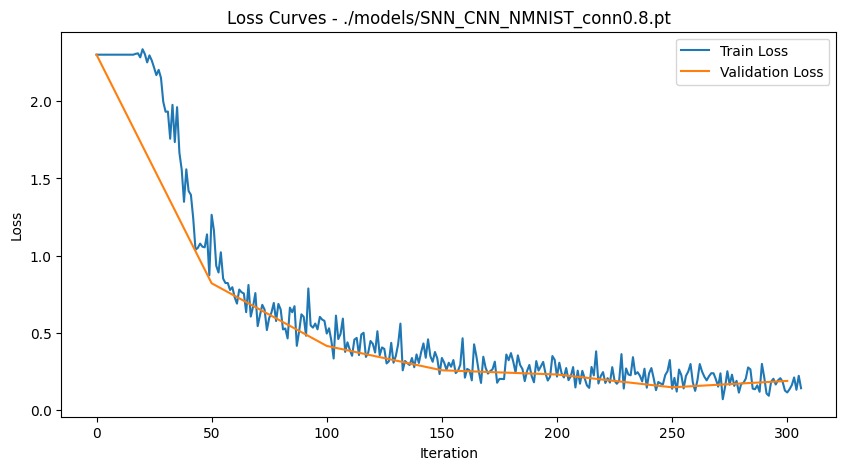

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 95.37%


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 6.12%
----------------
Iteration: 50
Training loss: 1.47
Validation loss: 1.30
Validation accuracy: 57.65%
Training accuracy: 52.04%
----------------
Iteration: 100
Training loss: 0.75
Validation loss: 0.71
Validation accuracy: 75.00%
Training accuracy: 77.04%
----------------
Iteration: 150
Training loss: 0.49
Validation loss: 0.41
Validation accuracy: 85.71%
Training accuracy: 85.71%
----------------
Iteration: 200
Training loss: 0.27
Validation loss: 0.41
Validation accuracy: 88.78%
Training accuracy: 91.84%
----------------
Iteration: 250
Training loss: 0.21
Validation loss: 0.18
Validation accuracy: 95.41%
Training accuracy: 92.86%
----------------
Iteration: 300
Training loss: 0.17
Validation loss: 0.25
Validation accuracy: 90.82%
Training accuracy: 93.37%
----------------


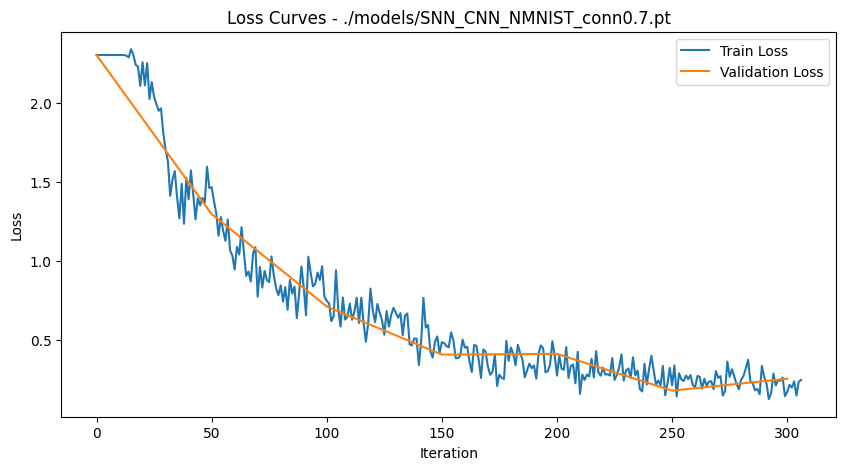

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 93.83%


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 6.12%
----------------
Iteration: 50
Training loss: 1.30
Validation loss: 0.99
Validation accuracy: 67.86%
Training accuracy: 59.18%
----------------
Iteration: 100
Training loss: 0.66
Validation loss: 0.56
Validation accuracy: 80.61%
Training accuracy: 82.14%
----------------
Iteration: 150
Training loss: 0.48
Validation loss: 0.28
Validation accuracy: 89.29%
Training accuracy: 85.20%
----------------
Iteration: 200
Training loss: 0.26
Validation loss: 0.30
Validation accuracy: 91.33%
Training accuracy: 93.88%
----------------
Iteration: 250
Training loss: 0.18
Validation loss: 0.19
Validation accuracy: 94.39%
Training accuracy: 95.41%
----------------
Iteration: 300
Training loss: 0.17
Validation loss: 0.27
Validation accuracy: 92.35%
Training accuracy: 93.88%
----------------


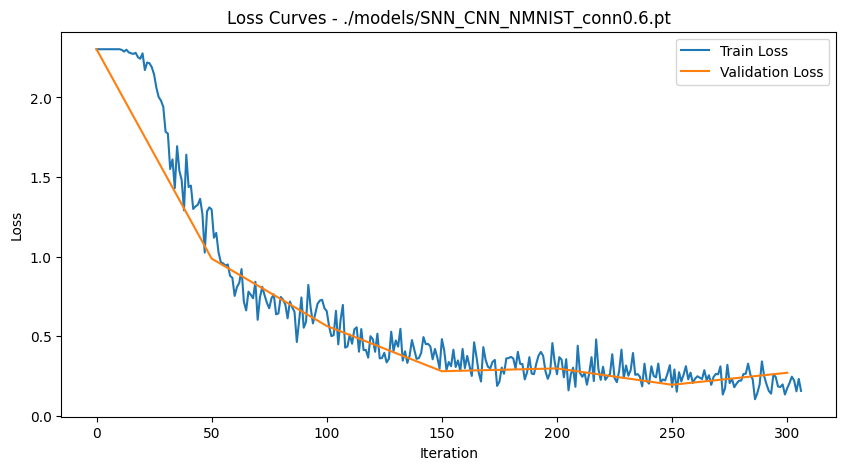

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 92.63%


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 6.12%
----------------
Iteration: 50
Training loss: 1.45
Validation loss: 1.09
Validation accuracy: 68.88%
Training accuracy: 58.67%
----------------
Iteration: 100
Training loss: 0.85
Validation loss: 0.68
Validation accuracy: 77.04%
Training accuracy: 69.90%
----------------
Iteration: 150
Training loss: 0.46
Validation loss: 0.33
Validation accuracy: 90.31%
Training accuracy: 84.69%
----------------
Iteration: 200
Training loss: 0.32
Validation loss: 0.41
Validation accuracy: 87.76%
Training accuracy: 88.78%
----------------
Iteration: 250
Training loss: 0.18
Validation loss: 0.21
Validation accuracy: 94.39%
Training accuracy: 93.37%
----------------
Iteration: 300
Training loss: 0.21
Validation loss: 0.32
Validation accuracy: 90.31%
Training accuracy: 93.37%
----------------


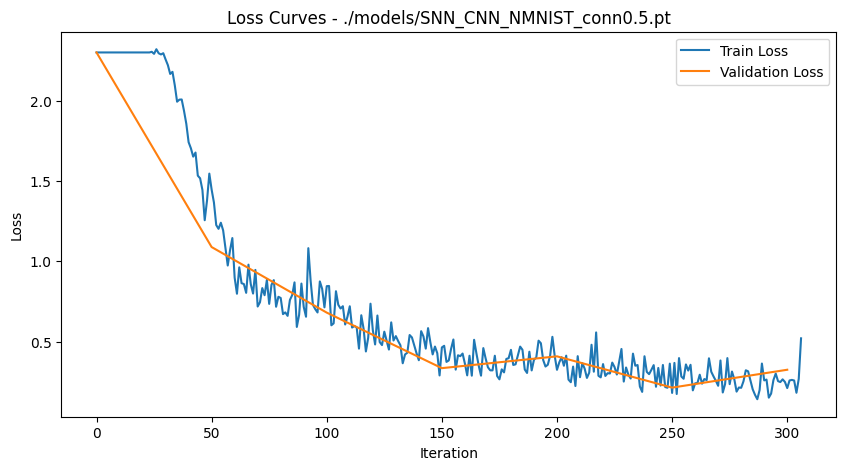

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 93.58%


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 6.12%
----------------
Iteration: 50
Training loss: 2.28
Validation loss: 2.27
Validation accuracy: 7.65%
Training accuracy: 9.18%
----------------
Iteration: 100
Training loss: 0.87
Validation loss: 0.80
Validation accuracy: 72.96%
Training accuracy: 71.94%
----------------
Iteration: 150
Training loss: 0.62
Validation loss: 0.45
Validation accuracy: 83.16%
Training accuracy: 80.10%
----------------
Iteration: 200
Training loss: 0.38
Validation loss: 0.45
Validation accuracy: 86.73%
Training accuracy: 89.29%
----------------
Iteration: 250
Training loss: 0.23
Validation loss: 0.24
Validation accuracy: 93.37%
Training accuracy: 92.35%
----------------
Iteration: 300
Training loss: 0.25
Validation loss: 0.33
Validation accuracy: 90.31%
Training accuracy: 89.80%
----------------


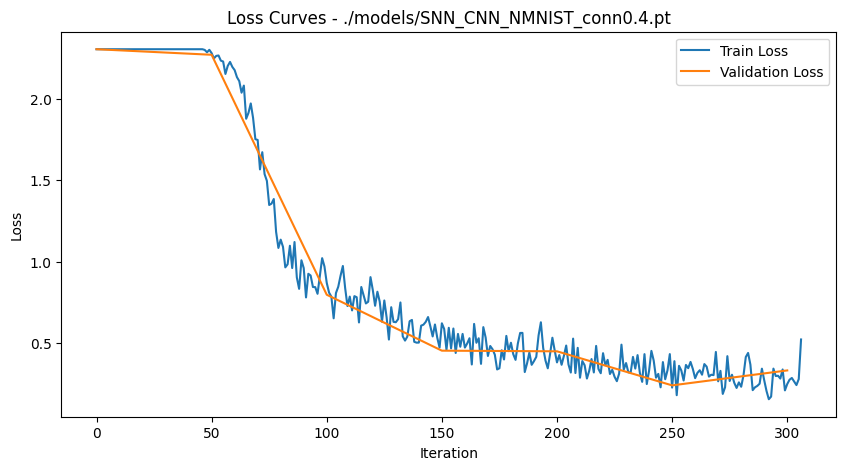

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 93.00%


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.37
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 9.18%
----------------
Iteration: 50
Training loss: 2.29
Validation loss: 2.30
Validation accuracy: 8.67%
Training accuracy: 9.69%
----------------
Iteration: 100
Training loss: 0.97
Validation loss: 0.98
Validation accuracy: 66.33%
Training accuracy: 65.31%
----------------
Iteration: 150
Training loss: 0.69
Validation loss: 0.52
Validation accuracy: 85.20%
Training accuracy: 76.53%
----------------
Iteration: 200
Training loss: 0.41
Validation loss: 0.48
Validation accuracy: 85.20%
Training accuracy: 87.24%
----------------
Iteration: 250
Training loss: 0.32
Validation loss: 0.28
Validation accuracy: 89.80%
Training accuracy: 88.78%
----------------
Iteration: 300
Training loss: 0.25
Validation loss: 0.40
Validation accuracy: 86.73%
Training accuracy: 91.33%
----------------


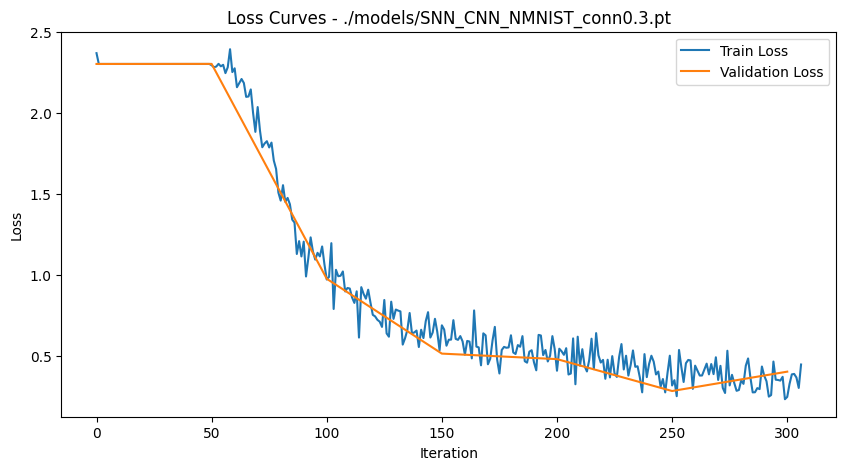

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 89.98%


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 6.12%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 7.65%
Training accuracy: 9.18%
----------------
Iteration: 100
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 8.16%
Training accuracy: 11.73%
----------------
Iteration: 150
Training loss: 1.23
Validation loss: 0.88
Validation accuracy: 71.43%
Training accuracy: 56.12%
----------------
Iteration: 200
Training loss: 0.65
Validation loss: 0.78
Validation accuracy: 76.53%
Training accuracy: 78.06%
----------------
Iteration: 250
Training loss: 0.55
Validation loss: 0.55
Validation accuracy: 85.71%
Training accuracy: 80.10%
----------------
Iteration: 300
Training loss: 0.53
Validation loss: 0.61
Validation accuracy: 79.59%
Training accuracy: 83.16%
----------------


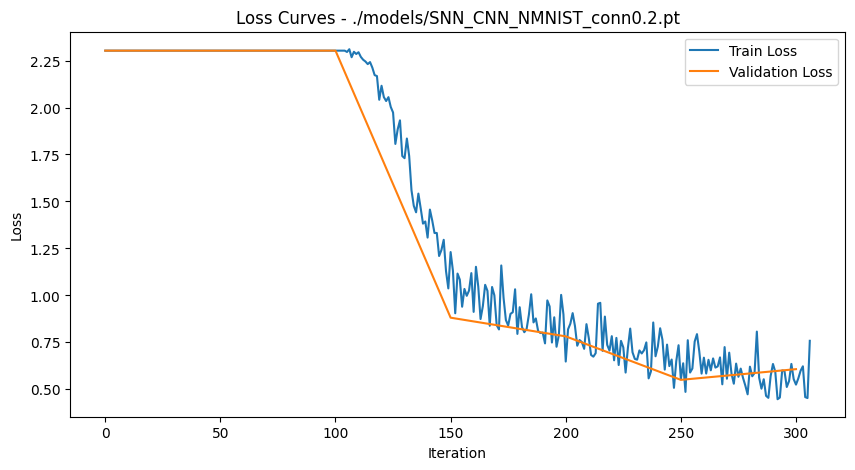

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 84.42%


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 6.12%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 7.65%
Training accuracy: 9.18%
----------------
Iteration: 100
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 8.16%
Training accuracy: 11.73%
----------------
Iteration: 150
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 11.73%
Training accuracy: 10.20%
----------------
Iteration: 200
Training loss: 1.89
Validation loss: 1.97
Validation accuracy: 20.92%
Training accuracy: 31.12%
----------------
Iteration: 250
Training loss: 0.92
Validation loss: 0.97
Validation accuracy: 63.78%
Training accuracy: 69.90%
----------------
Iteration: 300
Training loss: 0.70
Validation loss: 0.73
Validation accuracy: 76.02%
Training accuracy: 77.04%
----------------


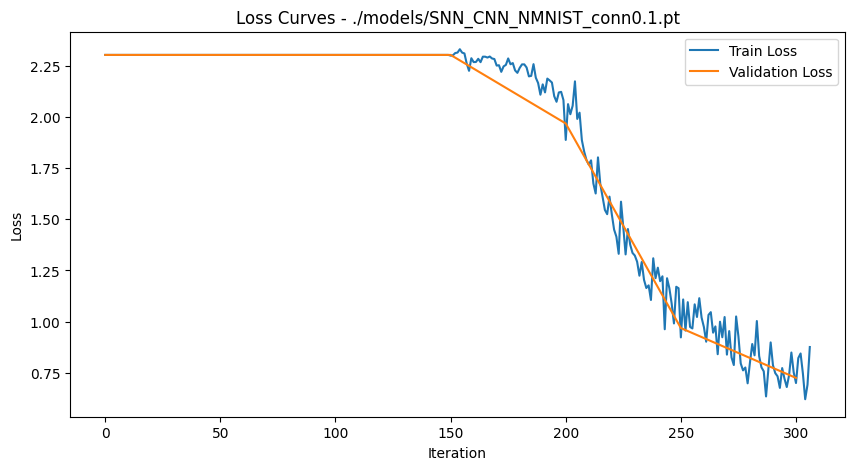

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 77.73%


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 6.12%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 7.65%
Training accuracy: 9.18%
----------------
Iteration: 100
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 8.16%
Training accuracy: 11.73%
----------------
Iteration: 150
Training loss: 2.28
Validation loss: 2.25
Validation accuracy: 21.43%
Training accuracy: 15.31%
----------------
Iteration: 200
Training loss: 1.48
Validation loss: 1.40
Validation accuracy: 50.00%
Training accuracy: 47.45%
----------------
Iteration: 250
Training loss: 1.10
Validation loss: 0.94
Validation accuracy: 65.82%
Training accuracy: 62.24%
----------------
Iteration: 300
Training loss: 0.89
Validation loss: 0.82
Validation accuracy: 73.98%
Training accuracy: 69.39%
----------------


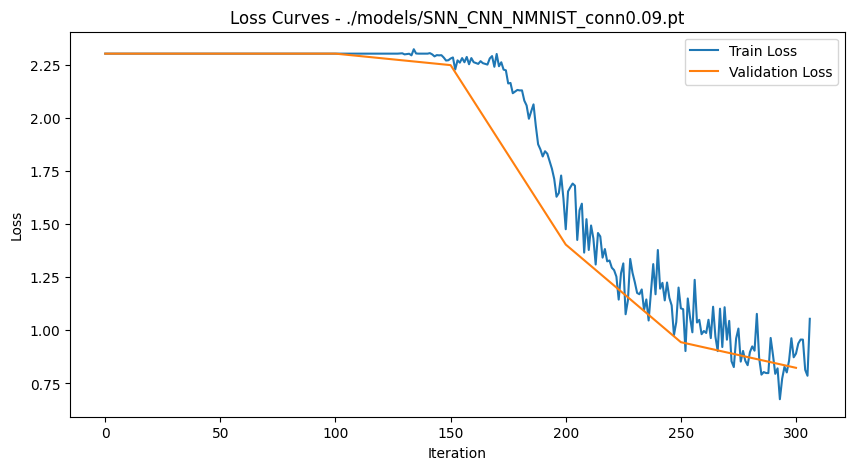

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 76.12%


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 6.12%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 7.65%
Training accuracy: 9.18%
----------------
Iteration: 100
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 8.16%
Training accuracy: 11.73%
----------------
Iteration: 150
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 11.73%
Training accuracy: 9.69%
----------------
Iteration: 200
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 5.61%
Training accuracy: 15.31%
----------------
Iteration: 250
Training loss: 2.26
Validation loss: 2.21
Validation accuracy: 20.41%
Training accuracy: 18.37%
----------------
Iteration: 300
Training loss: 2.08
Validation loss: 1.98
Validation accuracy: 30.61%
Training accuracy: 30.10%
----------------


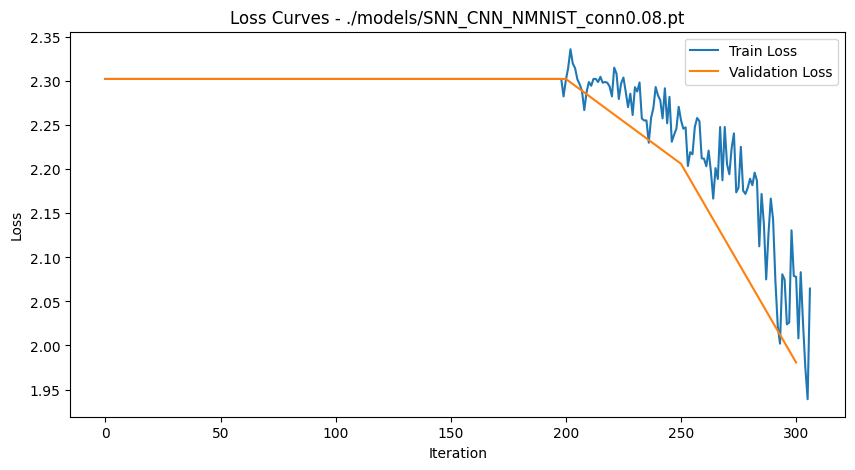

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 42.96%


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 6.12%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 7.65%
Training accuracy: 9.18%
----------------
Iteration: 100
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 8.16%
Training accuracy: 11.73%
----------------
Iteration: 150
Training loss: 2.29
Validation loss: 2.22
Validation accuracy: 21.94%
Training accuracy: 11.73%
----------------
Iteration: 200
Training loss: 2.14
Validation loss: 2.03
Validation accuracy: 33.67%
Training accuracy: 25.51%
----------------
Iteration: 250
Training loss: 1.44
Validation loss: 1.27
Validation accuracy: 58.16%
Training accuracy: 52.04%
----------------
Iteration: 300
Training loss: 1.03
Validation loss: 0.89
Validation accuracy: 71.94%
Training accuracy: 64.80%
----------------


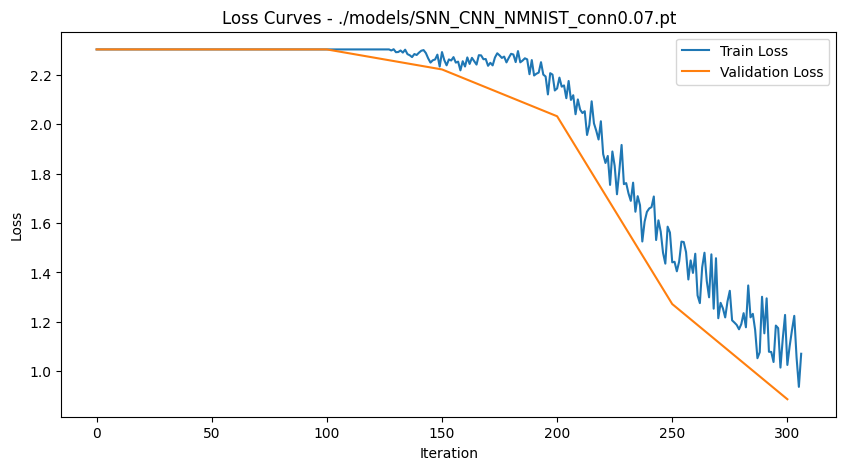

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 73.08%


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 6.12%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 7.65%
Training accuracy: 9.18%
----------------
Iteration: 100
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 8.16%
Training accuracy: 11.73%
----------------
Iteration: 150
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 11.73%
Training accuracy: 9.69%
----------------
Iteration: 200
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 5.61%
Training accuracy: 14.29%
----------------
Iteration: 250
Training loss: 2.31
Validation loss: 2.30
Validation accuracy: 8.67%
Training accuracy: 12.76%
----------------
Iteration: 300
Training loss: 2.25
Validation loss: 2.27
Validation accuracy: 13.27%
Training accuracy: 19.39%
----------------


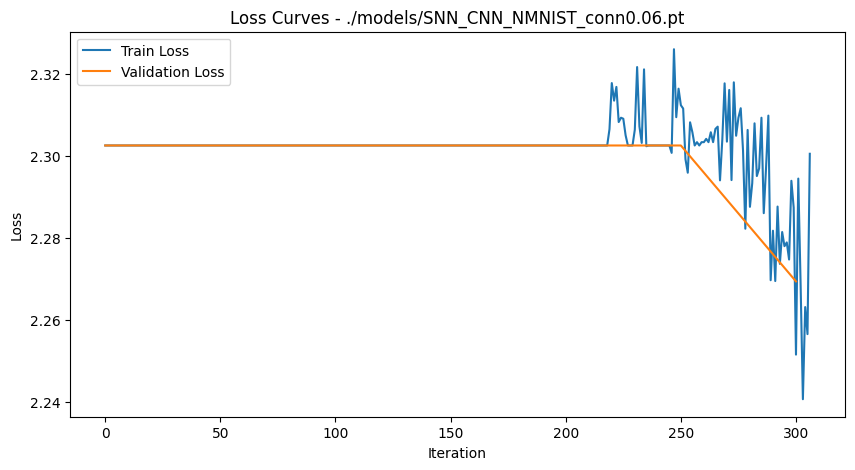

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 14.39%


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 6.12%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 7.65%
Training accuracy: 9.18%
----------------
Iteration: 100
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 8.16%
Training accuracy: 11.73%
----------------
Iteration: 150
Training loss: 2.30
Validation loss: 2.35
Validation accuracy: 11.22%
Training accuracy: 9.69%
----------------
Iteration: 200
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 5.61%
Training accuracy: 14.29%
----------------
Iteration: 250
Training loss: 2.34
Validation loss: 2.33
Validation accuracy: 12.76%
Training accuracy: 12.24%
----------------
Iteration: 300
Training loss: 2.31
Validation loss: 2.30
Validation accuracy: 8.16%
Training accuracy: 11.22%
----------------


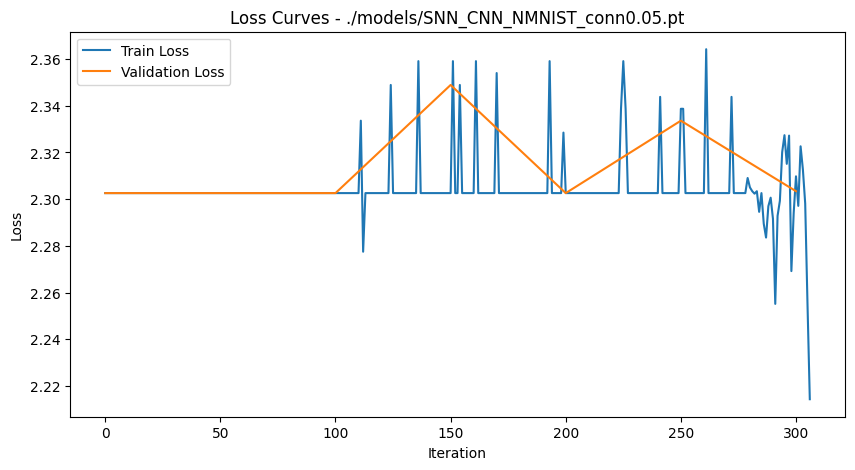

Testing progress::   0%|          | 0/52 [00:00<?, ?it/s]

Test Accuracy: 16.28%


Training progress::   0%|          | 0/307 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.34
Validation loss: 2.30
Validation accuracy: 9.18%
Training accuracy: 11.73%
----------------
Iteration: 50
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 7.65%
Training accuracy: 9.18%
----------------
Iteration: 100
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 8.16%
Training accuracy: 11.73%
----------------
Iteration: 150
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 11.73%
Training accuracy: 9.69%
----------------
Iteration: 200
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 5.61%
Training accuracy: 14.29%
----------------
Iteration: 250
Training loss: 2.30
Validation loss: 2.30
Validation accuracy: 8.67%
Training accuracy: 12.76%
----------------


KeyboardInterrupt: 

In [5]:
#with and without deepr
model_path = "./models/SNN_CNN_NMNIST.pt"
net = Net()
optimiser = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=0)
gen_reset() #reset the PRNG generators for the random samplers so we consistently get the same sequence of samples for each experiment run
net = trainer(net,train_loader=train_loader,valid_loader=test_loader,model_path=model_path,optimiser=optimiser,epochs=1,deepr=False,device=device)
gen_reset()
baseline_accuracy = test_stats(net,test_loader=test_loader,device=device)
print("----")

connectivities = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05]

accuracies = []

for c in connectivities:
    model_path = "./models/SNN_CNN_NMNIST_conn"+str(c)+".pt"
    net = Net(c)
    optimiser = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=0)
    gen_reset()
    net = trainer(net,train_loader=train_loader,valid_loader=test_loader,model_path=model_path,optimiser=optimiser,epochs=1,deepr=True,device=device)
    gen_reset()
    a = test_stats(net,test_loader=test_loader,device=device)
    accuracies.append(a)

with open("./pickles/SNN_CNN_NMNIST_baseline", "wb") as f:
    pickle.dump(baseline_accuracy,f)

with open("./pickles/SNN_CNN_NMNIST_deepr_accuracies", "wb") as f:
    pickle.dump(accuracies,f)

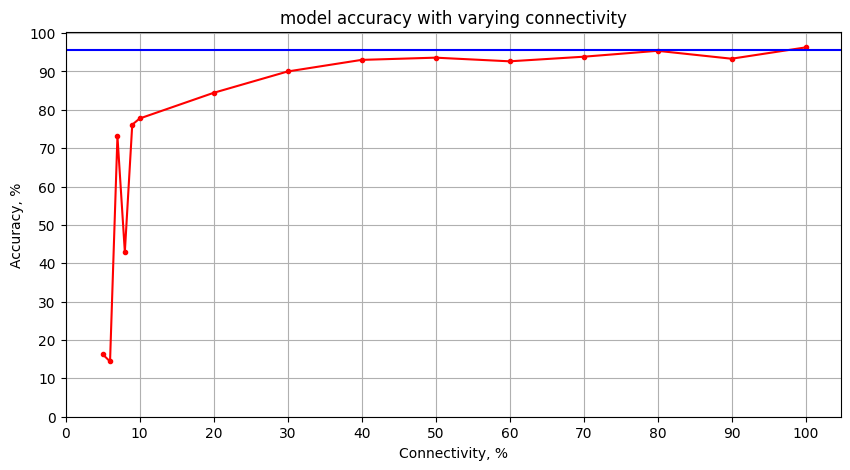

In [8]:
#performed early halting on above
#connectivities = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05]

fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot([c*100 for c in connectivities],[a*100 for a in accuracies],'.r-')
plt.axhline(y = baseline_accuracy*100, color = 'b', linestyle = '-')
plt.title("model accuracy with varying connectivity")
plt.xlabel("Connectivity, %")
plt.ylabel("Accuracy, %")
plt.xticks(range(0,101,10))
plt.yticks(range(0,101,10))
plt.grid(True)
plt.show()